In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-01-26 16:13:50 Configured OSMnx 1.1.1
2023-01-26 16:13:50 HTTP response caching is on


In [2]:
city = 'Guadalajara' #Ejemplo acotado a Guadalajara

## Download data from db

Whole metropolitan area

(6003, 433)


<AxesSubplot:>

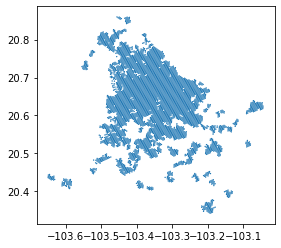

In [3]:
# download hexagons with pop data
hex_schema = 'censo'
hex_folder = 'hex_censo_10_20_mza_res9'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop = aup.gdf_from_query(query, geometry_col='geometry')

print(hex_pop.shape)
hex_pop.head(2)
hex_pop.plot()

2km from Adolfo Lopez Mateos

In [4]:
hex_schema = 'segundopiso'
hex_folder = 'censo1020_mza_hexres9_buffer2km'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop_2km = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_pop_2km.shape)

(853, 439)


1km from Adolfo Lopez Mateos

In [5]:
hex_schema = 'segundopiso'
hex_folder = 'censo1020_mza_hexres9_buffer1km'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop_1km = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_pop_1km.shape)

(472, 439)


500m from Adolfo Lopez Mateos

In [6]:
hex_schema = 'segundopiso'
hex_folder = 'censo1020_mza_hexres9_buffer500m'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop_500m = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_pop_500m.shape)

(272, 439)


## Data treatment

### Vivienda habitada de acuerdo a servicios

In [7]:
#Tomamos el máximo de viv con electricidad, con agua y con drenaje y lo tomamos como vivienda habitada 
#de acuerdo a los servicios que tiene (viv_serv)

hex_pop['viv_serv'] = hex_pop[['vph_c_elec','vph_aguadv','vph_drenaj']].max(axis=1)
hex_pop['10_viv_serv'] = hex_pop[['10_vph_c_elec','10_vph_aguadv','10_vph_drenaj']].max(axis=1)

hex_pop_500m['viv_serv'] = hex_pop_500m[['vph_c_elec','vph_aguadv','vph_drenaj']].max(axis=1)
hex_pop_500m['10_viv_serv'] = hex_pop_500m[['10_vph_c_elec','10_vph_aguadv','10_vph_drenaj']].max(axis=1)

hex_pop_1km['viv_serv'] = hex_pop_1km[['vph_c_elec','vph_aguadv','vph_drenaj']].max(axis=1)
hex_pop_1km['10_viv_serv'] = hex_pop_1km[['10_vph_c_elec','10_vph_aguadv','10_vph_drenaj']].max(axis=1)

hex_pop_2km['viv_serv'] = hex_pop_2km[['vph_c_elec','vph_aguadv','vph_drenaj']].max(axis=1)
hex_pop_2km['10_viv_serv'] = hex_pop_2km[['10_vph_c_elec','10_vph_aguadv','10_vph_drenaj']].max(axis=1)

### Cálculo del cambio de porcentaje de viviendas con auto 2010 - 2020

In [8]:
hex_pop['%vivconauto'] = (hex_pop['vph_autom'] / hex_pop['viv_serv'])*100
hex_pop['10_%vivconauto'] = (hex_pop['10_vph_autom'] / hex_pop['10_viv_serv'])*100
hex_pop['chg_%vivconauto_10_20'] = hex_pop['%vivconauto'] - hex_pop['10_%vivconauto']

hex_pop_500m['%vivconauto'] = (hex_pop_500m['vph_autom'] / hex_pop_500m['viv_serv'])*100
hex_pop_500m['10_%vivconauto'] = (hex_pop_500m['10_vph_autom'] / hex_pop_500m['10_viv_serv'])*100
hex_pop_500m['chg_%vivconauto_10_20'] = hex_pop_500m['%vivconauto'] - hex_pop_500m['10_%vivconauto']

hex_pop_1km['%vivconauto'] = (hex_pop_1km['vph_autom'] / hex_pop_1km['viv_serv'])*100
hex_pop_1km['10_%vivconauto'] = (hex_pop_1km['10_vph_autom'] / hex_pop_1km['10_viv_serv'])*100
hex_pop_1km['chg_%vivconauto_10_20'] = hex_pop_1km['%vivconauto'] - hex_pop_1km['10_%vivconauto']

hex_pop_2km['%vivconauto'] = (hex_pop_2km['vph_autom'] / hex_pop_2km['viv_serv'])*100
hex_pop_2km['10_%vivconauto'] = (hex_pop_2km['10_vph_autom'] / hex_pop_2km['10_viv_serv'])*100
hex_pop_2km['chg_%vivconauto_10_20'] = hex_pop_2km['%vivconauto'] - hex_pop_2km['10_%vivconauto']

# Save to Database before analysis

In [9]:
aup.gdf_to_db_slow(hex_pop_500m,"censo1020_mza_hexres9_buffer500m", 'segundopiso', if_exists='replace')
aup.gdf_to_db_slow(hex_pop_1km,"censo1020_mza_hexres9_buffer1km", 'segundopiso', if_exists='replace')
aup.gdf_to_db_slow(hex_pop_2km,"censo1020_mza_hexres9_buffer2km", 'segundopiso', if_exists='replace')
aup.gdf_to_db_slow(hex_pop,"censo1020_mza_hexres9_guadalajara", 'segundopiso', if_exists='replace')

# Data analysis

### Divide north/south

In [10]:
hex_pop_500m_nte = hex_pop_500m[hex_pop_500m['ubicacion']=='Norte del periferico']
hex_pop_500m_sur = hex_pop_500m[hex_pop_500m['ubicacion']=='Sur del periferico']

hex_pop_1km_nte = hex_pop_1km[hex_pop_1km['ubicacion']=='Norte del periferico']
hex_pop_1km_sur = hex_pop_1km[hex_pop_1km['ubicacion']=='Sur del periferico']

hex_pop_2km_nte = hex_pop_2km[hex_pop_2km['ubicacion']=='Norte del periferico']
hex_pop_2km_sur = hex_pop_2km[hex_pop_2km['ubicacion']=='Sur del periferico']

## Prueba con iteración

In [23]:
hexs_lst = [hex_pop_500m_nte,hex_pop_500m_sur,hex_pop_1km_nte,hex_pop_1km_sur,hex_pop_2km_nte,hex_pop_2km_sur,hex_pop]
hexs_strlst = ['hex_pop_500m_nte','hex_pop_500m_sur','hex_pop_1km_nte','hex_pop_1km_sur','hex_pop_2km_nte','hex_pop_2km_sur','hex_pop']
            
variable_lst = ['pobtot', 'vivtot','tvivparhab','viv_serv', 'vph_autom', 
                '10_pobtot', '10_vivtot','10_viv_serv','10_vph_autom']

summ_df = pd.DataFrame()

a = 0

for hexs in hexs_lst:
    for field in hexs:
        for variable in variable_lst:
            if field == variable:
                summ_df.loc[hexs_strlst[a],field] = hexs[field].sum()
    a = a + 1

summ_df

,pobtot,vivtot,tvivparhab,vph_autom,10_pobtot,10_vivtot,10_vph_autom,viv_serv,10_viv_serv
hex_pop_500m_nte,92453.0,38552.0,33526.0,27440.0,94426.0,34509.0,24037.0,33488.0,28314.0
hex_pop_500m_sur,50426.0,17539.0,14047.0,9961.0,44640.0,13777.0,7033.0,13994.0,10456.0
hex_pop_1km_nte,185143.0,75484.0,65575.0,52176.0,195294.0,69787.0,47185.0,65495.0,57482.0
hex_pop_1km_sur,98745.0,34490.0,27771.0,20200.0,81976.0,24991.0,13169.0,27687.0,19214.0
hex_pop_2km_nte,383234.0,149828.0,130755.0,97463.0,399634.0,137374.0,88773.0,129425.0,114356.0
hex_pop_2km_sur,189554.0,66015.0,54271.0,39024.0,154608.0,47384.0,25186.0,54155.0,37024.0
hex_pop,5120219.0,1732948.0,1434897.0,802301.0,4374540.0,1315505.0,622197.0,1425313.0,1057102.0


In [24]:
#Código a estudiar después
#hex_pop_2km['pct_vph_autom'] = hex_pop_2km['vph_autom']/hex_pop_2km['viv_serv']
#hex_pop_2km.loc[(hex_pop_2km['ubicacion']=='Sur del periferico'),'pct_vph_autom'].mean()

## Calculate cambio en %viv con auto por zona

In [25]:
summ_df['%vivconauto'] = (summ_df['vph_autom'] / summ_df['tvivparhab'])*100
summ_df['10_%vivconauto'] = (summ_df['10_vph_autom'] / summ_df['10_viv_serv'])*100
summ_df['%vivconauto_10_20'] = summ_df['%vivconauto'] - summ_df['10_%vivconauto']

summ_df

,pobtot,vivtot,tvivparhab,vph_autom,10_pobtot,10_vivtot,10_vph_autom,viv_serv,10_viv_serv,%vivconauto,10_%vivconauto,%vivconauto_10_20
hex_pop_500m_nte,92453.0,38552.0,33526.0,27440.0,94426.0,34509.0,24037.0,33488.0,28314.0,81.846925,84.894399,-3.047474
hex_pop_500m_sur,50426.0,17539.0,14047.0,9961.0,44640.0,13777.0,7033.0,13994.0,10456.0,70.911938,67.262816,3.649123
hex_pop_1km_nte,185143.0,75484.0,65575.0,52176.0,195294.0,69787.0,47185.0,65495.0,57482.0,79.566908,82.086566,-2.519658
hex_pop_1km_sur,98745.0,34490.0,27771.0,20200.0,81976.0,24991.0,13169.0,27687.0,19214.0,72.737748,68.538566,4.199182
hex_pop_2km_nte,383234.0,149828.0,130755.0,97463.0,399634.0,137374.0,88773.0,129425.0,114356.0,74.538641,77.628633,-3.089992
hex_pop_2km_sur,189554.0,66015.0,54271.0,39024.0,154608.0,47384.0,25186.0,54155.0,37024.0,71.905806,68.026145,3.879661
hex_pop,5120219.0,1732948.0,1434897.0,802301.0,4374540.0,1315505.0,622197.0,1425313.0,1057102.0,55.913491,58.858748,-2.945257


In [28]:
summ_df['%chg_pobtot'] = ((summ_df['pobtot'] -summ_df['10_pobtot']) / summ_df['10_pobtot'])*100
summ_df

,pobtot,vivtot,tvivparhab,vph_autom,10_pobtot,10_vivtot,10_vph_autom,viv_serv,10_viv_serv,%vivconauto,10_%vivconauto,%vivconauto_10_20,%chg_pobtot
hex_pop_500m_nte,92453.0,38552.0,33526.0,27440.0,94426.0,34509.0,24037.0,33488.0,28314.0,81.846925,84.894399,-3.047474,-2.089467
hex_pop_500m_sur,50426.0,17539.0,14047.0,9961.0,44640.0,13777.0,7033.0,13994.0,10456.0,70.911938,67.262816,3.649123,12.961470
hex_pop_1km_nte,185143.0,75484.0,65575.0,52176.0,195294.0,69787.0,47185.0,65495.0,57482.0,79.566908,82.086566,-2.519658,-5.197804
hex_pop_1km_sur,98745.0,34490.0,27771.0,20200.0,81976.0,24991.0,13169.0,27687.0,19214.0,72.737748,68.538566,4.199182,20.455987
hex_pop_2km_nte,383234.0,149828.0,130755.0,97463.0,399634.0,137374.0,88773.0,129425.0,114356.0,74.538641,77.628633,-3.089992,-4.103755
hex_pop_2km_sur,189554.0,66015.0,54271.0,39024.0,154608.0,47384.0,25186.0,54155.0,37024.0,71.905806,68.026145,3.879661,22.602970
hex_pop,5120219.0,1732948.0,1434897.0,802301.0,4374540.0,1315505.0,622197.0,1425313.0,1057102.0,55.913491,58.858748,-2.945257,17.045884
